# Artificial Intelligence II - Homework 4
---
## Fine-tuned on TriviaQA Dataset - Part 3
---
### Δημήτριος Σιταράς | 1115201800178
---

## Libraries n' Functions

In [22]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
import json
import math

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
device

device(type='cuda')

In [12]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()

In [ ]:
def lossCurve(trainLosses,valLosses):
  plt.plot(trainLosses, color="r")
  plt.plot(valLosses, color="g")
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['Train Loss','Validation Loss'])
  plt.show()

In [14]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 4.0 MB/s 
     |████████████████████████████████| 895 kB 40.3 MB/s 
     |████████████████████████████████| 596 kB 38.8 MB/s 
     |████████████████████████████████| 67 kB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 36.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Download Trivia Dataset and convert it to SQuAD format

In [5]:
!git clone https://github.com/amazon-research/qa-dataset-converter

Cloning into 'qa-dataset-converter'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 27 (delta 8), reused 9 (delta 1), pack-reused 0
Unpacking objects: 100% (27/27), done.


In [ ]:
!wget https://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz

--2022-03-12 13:33:36--  https://nlp.cs.washington.edu/triviaqa/data/triviaqa-rc.tar.gz
Resolving nlp.cs.washington.edu (nlp.cs.washington.edu)... 128.208.3.120, 2607:4000:200:12::78
Connecting to nlp.cs.washington.edu (nlp.cs.washington.edu)|128.208.3.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2665779500 (2.5G) [application/x-gzip]
Saving to: ‘triviaqa-rc.tar.gz’

triviaqa-rc.tar.gz  100%[===================>]   2.48G  21.1MB/s    in 2m 11s  

2022-03-12 13:35:47 (19.4 MB/s) - ‘triviaqa-rc.tar.gz’ saved [2665779500/2665779500]



In [ ]:
import tarfile
fname = "triviaqa-rc.tar.gz"
if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [ ]:
!git clone https://github.com/mandarjoshi90/triviaqa

Cloning into 'triviaqa'...
remote: Enumerating objects: 67, done.
remote: Total 67 (delta 0), reused 0 (delta 0), pack-reused 67
Unpacking objects: 100% (67/67), done.


In [ ]:
!mv qa-dataset-converter/triviaqa/triviaqa_to_squad.py  triviaqa/

In [ ]:
import nltk
nltk.download('punkt')
!python triviaqa/triviaqa_to_squad.py --triviaqa_file qa/wikipedia-dev.json --data_dir evidence/wikipedia/ --output_file triviaqa_dev.json
!python triviaqa/triviaqa_to_squad.py --triviaqa_file qa/wikipedia-train.json --data_dir evidence/wikipedia/ --output_file triviaqa_train.json

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Take the texts, questions and answers from Trivia dataset and insert these into corresponding lists

In [ ]:
jsonTrain = "./triviaqa_train.json"
jsonVal = "./triviaqa_dev.json"

file_data = pd.read_json(jsonTrain)
json_data = file_data['data']

size = math.floor(json_data.shape[0]*0.7)
trainContents = file_data['data'].loc[0:size]

file_data = pd.read_json(jsonVal)
json_data = file_data['data']

size = math.floor(json_data.shape[0])
valContents = file_data['data'].loc[0:size]

In [ ]:
def jsonToLists(contents):
  texts=[]
  questions=[]
  answers=[]
  for data in contents:
    for txt in data['paragraphs']: # every text,
      text = txt['context']
      for qa in txt['qas']: # has many questions,
        question = qa['question']
        for answer in qa['answers']: # questions have answers.
          texts.append(text)
          questions.append(question)
          answers.append(answer)            
                  
  return texts,questions,answers


In [ ]:
trainTexts,trainQuestions,trainAnswers=jsonToLists(trainContents)
valTexts,valQuestions,valAnswers=jsonToLists(valContents)

In [ ]:
print(len(trainTexts))
print(len(trainQuestions))
print(len(trainAnswers))
print("-----")
print(len(valTexts))
print(len(valQuestions))
print(len(valAnswers))

54482
54482
54482
-----
9842
9842
9842


## Find and store the end position of every answer

In [ ]:
def add_end_idx(answers, contexts):
    # get the character position at which every answer ends and store it
    for answer, context in zip(answers, contexts):
      end_idx = answer['answer_start'] + len(answer['text'])

      if context[answer['answer_start']:end_idx] == answer['text']:
        answer['answer_end'] = end_idx
      # Sometimes SQuAD answers are off by one or two characters, so ...
      elif context[answer['answer_start']-1:end_idx-1] == answer['text']:
        answer['answer_start'] = answer['answer_start'] - 1
        answer['answer_end'] = end_idx - 1
      elif context[answer['answer_start']-2:end_idx-2] == answer['text']:
        answer['answer_start'] = answer['answer_start'] - 2
        answer['answer_end'] = end_idx - 2
                
add_end_idx(trainAnswers, trainTexts)
add_end_idx(valAnswers, valTexts)

## BERT Tokenizer

In [15]:
from transformers import BertTokenizerFast,DistilBertTokenizerFast

# tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
trainEncodings=tokenizer(trainTexts,trainQuestions, truncation=True, padding=True, max_length=512)
valEncodings=tokenizer(valTexts,valQuestions, truncation=True, padding=True, max_length=512)

## Convert  character start/end positions to token start/end positions

In [ ]:
def add_token_positions(encodings, answers):
    # convert character start/end positions to token start/end positions.
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        if(answers[i]['answer_end']==0):
            end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'])) 
        else:
            end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

         # if None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
                   
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(trainEncodings, trainAnswers)
add_token_positions(valEncodings, valAnswers)

## Custom Dataset

In [ ]:
class SquadDataset(torch.utils.data.Dataset):
  def __init__(self, encodings):
    self.encodings = encodings

  def __getitem__(self, idx):
    return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

  def __len__(self):
    return len(self.encodings.input_ids)

# create the corresponding datasets
trainSet = SquadDataset(trainEncodings)
valSet = SquadDataset(valEncodings)

## Build/Load the Bert model

In [ ]:
from transformers import BertForQuestionAnswering,DistilBertForQuestionAnswering
modelTrivia = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
# model = DistilBertForQuestionAnswering.from_pretrained('distilbert-base-uncased')
modelTrivia.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 16
trainDataloader = DataLoader(trainSet, batch_size=batch_size, shuffle=True)
valDataloader = DataLoader(valSet, batch_size=batch_size, shuffle=False)

In [ ]:
lr = 1e-5
optimizer = torch.optim.AdamW(modelTrivia.parameters(), lr=lr)

## Train and evalute the Bert model

In [ ]:
epochs = 2
trainLosses=[]
valLosses=[]

for i in range(epochs):
  batchLosses = []
  modelTrivia.train() # training mode

  for batch in trainDataloader:
    
    optimizer.zero_grad() # Delete previously stored gradients

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = modelTrivia(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)

    batchLosses.append(outputs[0].item())  

    outputs[0].backward() # Perform backpropagation starting from the loss calculated in this epoch

    nn.utils.clip_grad_norm_(modelTrivia.parameters(),5.0) # Clip gradients to avoid vanishing gradients

    optimizer.step() # Update model's weights based on the gradients calculated during backprop


  trainCurrentLoss = sum(batchLosses)/len(trainDataloader)
  trainLosses.append(trainCurrentLoss) 

 
  with torch.no_grad(): # evaluation, don't calculate gradients
    modelTrivia.eval() # evaluation mode
    batchLosses = []
    for batch in valDataloader:

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      output = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      batchLosses.append(output[0].item())

  valCurrentLoss = sum(batchLosses)/len(valDataloader)
  valLosses.append(valCurrentLoss)
  print("-Epoch: {}/{}...".format(i+1, epochs), "Train Loss: {:.6f} |".format(trainCurrentLoss), "Val Loss: {:.6f}".format(valCurrentLoss))

-Epoch: 1/2... Train Loss: 2.746614 | Val Loss: 1.893155
-Epoch: 2/2... Train Loss: 1.633667 | Val Loss: 1.711454


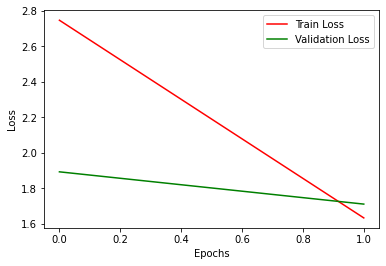

In [ ]:
lossCurve(trainLosses,valLosses)

In [18]:
def predictTheAnswer(text,question,model):
  inputs = tokenizer.encode_plus(question, text, return_tensors='pt',max_length=512, truncation=True).to(device)

  outputs = model(**inputs)
  answer_start = torch.argmax(outputs[0])
  answer_end = torch.argmax(outputs[1]) + 1 

  answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs['input_ids'][0][answer_start:answer_end]))
  return answer

In [19]:
def prediction(contents,model):
  predAnswers={}
  for data in contents['data']:
    for txt in data['paragraphs']: 
      text = txt['context']
      for qa in txt['qas']:
        qid = qa['id']
        question = qa['question']
        predAnswers[qid]=predictTheAnswer(text,question,model)
  return predAnswers

In [ ]:
predAnswers=prediction(valContents,model)

In [ ]:
with open('results.txt', 'w') as convert_file:
     convert_file.write(json.dumps(predAnswers))

In [ ]:
!python evaluate-v2.0.py triviaqa_dev.json results.txt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "exact": 25.209080047789726,
  "f1": 28.63502153613684,
  "total": 14229,
  "HasAns_exact": 28.591749644381224,
  "HasAns_f1": 33.54477966243567,
  "HasAns_total": 9842,
  "NoAns_exact": 17.620241622976977,
  "NoAns_f1": 17.620241622976977,
  "NoAns_total": 4387
}


## SQuAD 2.0

In [ ]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
jsonVal = "dev-v2.0.json"

with open(jsonVal, 'r') as j:
     squadContents = json.loads(j.read())

--2022-03-10 23:26:56--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4370528 (4.2M) [application/json]
Saving to: ‘dev-v2.0.json’

dev-v2.0.json       100%[===================>]   4.17M  --.-KB/s    in 0.1s    

2022-03-10 23:26:57 (36.3 MB/s) - ‘dev-v2.0.json’ saved [4370528/4370528]



In [ ]:
predAnswersTrivia=prediction(squadContents,modelTrivia)

In [ ]:
with open('resultsSquadPredictedAnswers.txt', 'w') as convert_file:
     convert_file.write(json.dumps(predAnswersTrivia))

In [ ]:
!python evaluate-v2.0.py dev-v2.0.json resultsSquadPredictedAnswers.txt

{
  "exact": 15.27836267160785,
  "f1": 18.455467652468585,
  "total": 11873,
  "HasAns_exact": 12.449392712550607,
  "HasAns_f1": 18.812713805289885,
  "HasAns_total": 5928,
  "NoAns_exact": 18.09924306139613,
  "NoAns_f1": 18.09924306139613,
  "NoAns_total": 5945
}


## QUAC

In [ ]:
!wget https://s3.amazonaws.com/my89public/quac/val_v0.2.json

--2022-03-11 00:04:03--  https://s3.amazonaws.com/my89public/quac/val_v0.2.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.77.30
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.77.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8929167 (8.5M) [application/json]
Saving to: ‘val_v0.2.json’

val_v0.2.json       100%[===================>]   8.51M  35.9MB/s    in 0.2s    

2022-03-11 00:04:03 (35.9 MB/s) - ‘val_v0.2.json’ saved [8929167/8929167]



In [ ]:
!python /content/qa-dataset-converter/quac/quac_to_squad.py --quac_file val_v0.2.json --output_file quac_dev.json

In [ ]:
jsonValQuAC = "/content/quac_dev.json"

with open(jsonValQuAC, 'r') as j:
     QuACValContents = json.loads(j.read())

In [ ]:
predAnswersQuAC=prediction(QuACValContents,modelTrivia)

In [ ]:
with open('resultsQuACPredictedAnswers.txt', 'w') as convert_file:
     convert_file.write(json.dumps(predAnswersQuAC))

In [ ]:
!python evaluate-v2.0.py quac_dev.json resultsQuACPredictedAnswers.txt

{
  "exact": 4.405765569757955,
  "f1": 8.497801522440408,
  "total": 7354,
  "HasAns_exact": 0.5794137695978187,
  "HasAns_f1": 5.707708315614657,
  "HasAns_total": 5868,
  "NoAns_exact": 19.515477792732167,
  "NoAns_f1": 19.515477792732167,
  "NoAns_total": 1486
}


## NQ

In [ ]:
!python /content/qa-dataset-converter/nq/nq_to_squad.py --nq_dir "/content/drive/MyDrive/v1.0/dev" --output_file nq_dev.json


In [ ]:
jsonValnatural = "/content/nq_dev.json"

with open(jsonValnatural, 'r') as j:
     naturalValContents = json.loads(j.read())

In [ ]:
predAnswersNatural=prediction(naturalValContents,modelTrivia)

In [ ]:
with open('resultsNaturalPredictedAnswers.txt', 'w') as convert_file:
     convert_file.write(json.dumps(predAnswersNatural))

In [ ]:
!python evaluate-v2.0.py nq_dev.json resultsNaturalPredictedAnswers.txt

{
  "exact": 16.087859899079845,
  "f1": 21.043960703422968,
  "total": 3369,
  "HasAns_exact": 16.68081494057725,
  "HasAns_f1": 23.767870802135825,
  "HasAns_total": 2356,
  "NoAns_exact": 14.70878578479763,
  "NoAns_f1": 14.70878578479763,
  "NoAns_total": 1013
}


## NewsQA

In [ ]:
!python /content/qa-dataset-converter/newsqa/newsqa_to_squad.py --newsqa_file /content/drive/MyDrive/datasets/newsqa_dev.json --output_file newsqa_dev.json

In [16]:
jsonValnatural = "/content/newsqa_dev.json"

with open(jsonValnatural, 'r') as j:
     newsQAValContents = json.loads(j.read())

In [24]:
predAnswersnewsQA=prediction(newsQAValContents,modelTrivia)

In [25]:
with open('resultsnewsQAPredictedAnswers.txt', 'w') as convert_file:
     convert_file.write(json.dumps(predAnswersnewsQA))

In [26]:
!python evaluate-v2.0.py newsqa_dev.json resultsnewsQAPredictedAnswers.txt

{
  "exact": 7.665505226480836,
  "f1": 13.026323624906487,
  "total": 5166,
  "HasAns_exact": 7.665505226480836,
  "HasAns_f1": 13.026323624906487,
  "HasAns_total": 5166
}
